In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


In [2]:
df = pd.read_csv("results_full.csv")

metric = "RMSE"
df = df[df["metric"] == metric]
#df = df[df['suite_id'] == 336]

splits = [s for s in df["split_method"].unique() if s.lower() != "random_split"]
 
method_order = [
    'ConstantPredictor', 'LinearRegressor', 'RandomForestRegressor', 'LGBMRegressor',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'TabPFNRegressor', 'GPBoost_RMSE'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LinearRegressor': 'Linear Regression',
    'TabPFNRegressor': 'TabPFN',
    'GPBoost_RMSE': 'GPBoost'
}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

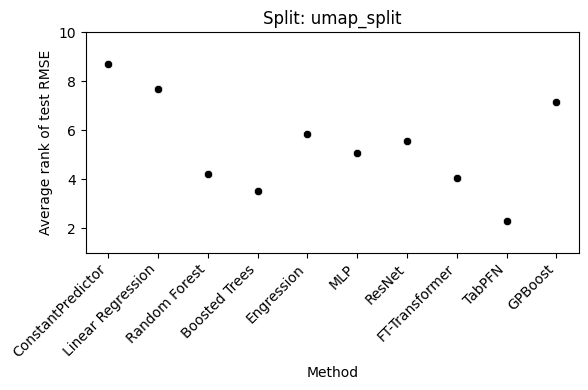

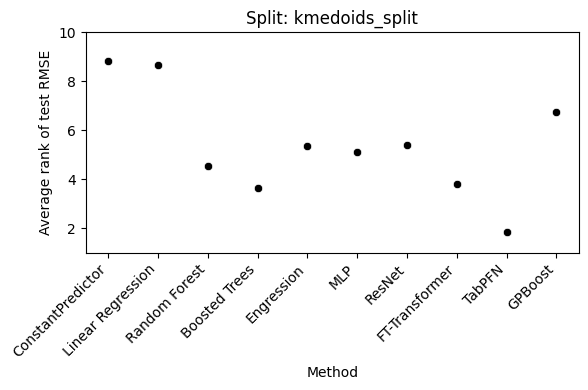

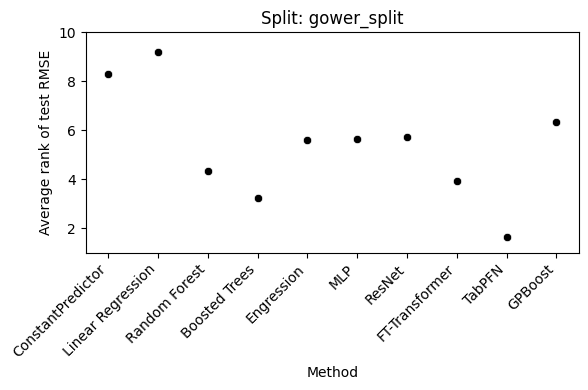

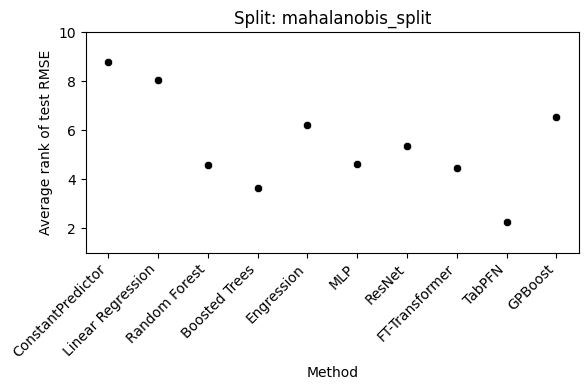

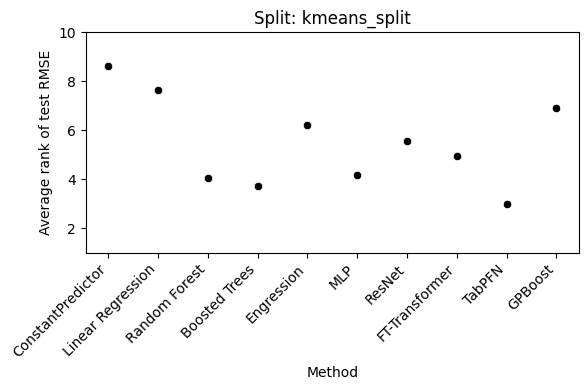

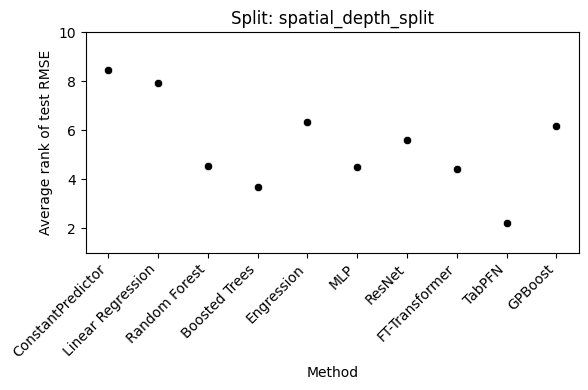

In [3]:
outdir = os.path.join('PICTURES', metric.lower())
os.makedirs(outdir, exist_ok=True)

for split in splits:
    sub = df[df["split_method"] == split]
    if sub.empty:
        continue

    table = sub.pivot(
        index="model",
        columns="task_id",
        values="value"
    )

    ranks = table.rank(ascending=True)  
    summary = pd.DataFrame({
        "Mean":   ranks.mean(axis=1),
        "Median": ranks.median(axis=1),
        "Std":    ranks.std(axis=1),
    }).reset_index().rename(columns={"model": "Method"})

    summary["Method"] = pd.Categorical(
        summary["Method"],
        categories=method_order,
        ordered=True
    )
    summary = summary.sort_values("Method")
    summary["Method"] = (
        summary["Method"]
        .astype(str)
        .map(rename_map)
        .fillna(summary["Method"].astype(str))
    )

    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=summary, x="Method", y="Mean", color='black')
    plt.xlabel("Method")
    plt.ylabel("Average rank of test RMSE")
    plt.title(f"Split: {split}")
    plt.ylim(1, 10)        
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # 6) save
    fname = f"{split}_rankings_{metric}.png"
    plt.savefig(os.path.join(outdir, fname), bbox_inches='tight')
    plt.show()


In [3]:
df = df[df["metric"] == "RMSE"]

df = df[df["split_method"] != "random_split"]

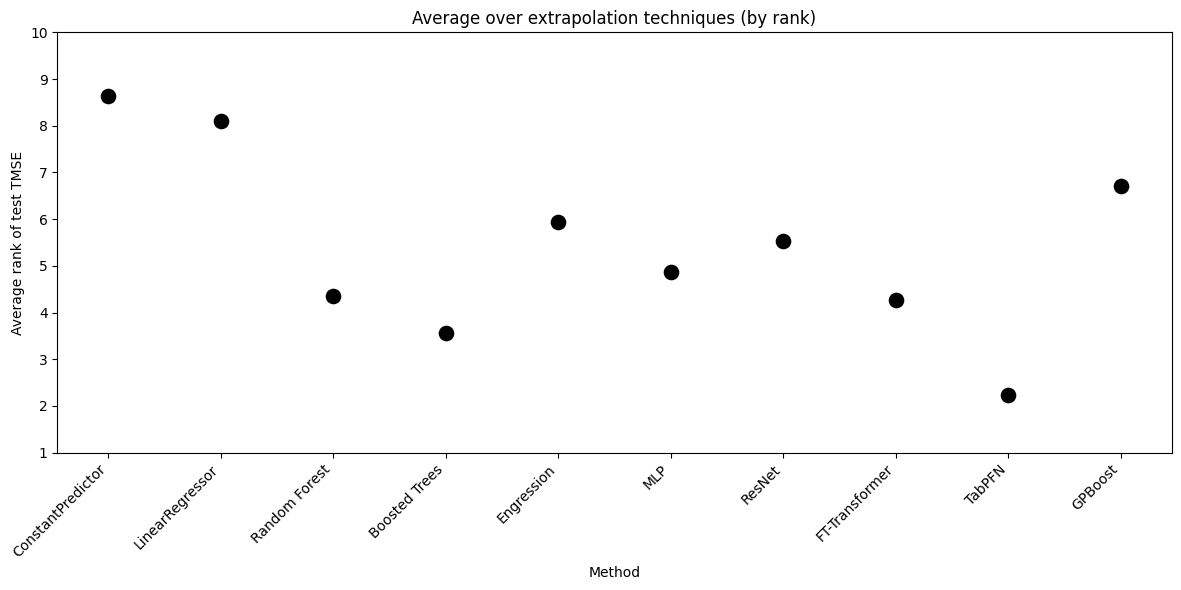

In [5]:
df["rank"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .rank(ascending=True)
)


overall = (
    df
    .groupby('model')['rank']
    .mean()
    .reset_index(name='Mean')
)


method_order = [
    'ConstantPredictor', 'LinearRegressor'
    , 'RandomForestRegressor', 'LGBMRegressor', 'Engression',
    'MLP', 'ResNet', 'FTTransformer', 'TabPFNRegressor', 'GPBoost_RMSE'
]
overall = overall.set_index('model').reindex(method_order).reset_index()

# 3) Map to display names
rename_map = {
    'RandomForestRegressor':'Random Forest',
    'LGBMRegressor':        'Boosted Trees',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'TabPFNRegressor':      'TabPFN',
    'GPBoost_RMSE':        'GPBoost'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])


plt.figure(figsize=(12,6))
sns.scatterplot(data=overall, x='Method', y='Mean', color='black', s=150)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average rank of test TMSE')
plt.xlabel('Method')
plt.title('Average over extrapolation techniques (by rank)')
plt.ylim(1, 10)
plt.tight_layout()

os.makedirs('PICTURES', exist_ok=True)
plt.savefig('PICTURES/average_rank_RMSE.png', bbox_inches='tight')
plt.show()


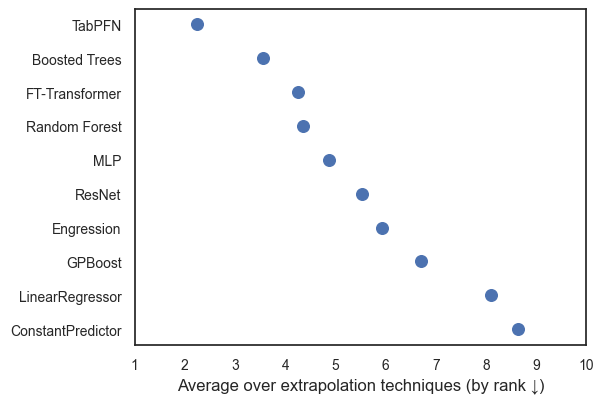

In [ ]:
sns.set_theme(style="white", rc={"axes.grid": False})   


plt.rcParams.update({
    "figure.figsize": (6.2, 4.2),   # taller than 12x6
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})


df["rank"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .rank(ascending=True)
)


overall = (
    df
    .groupby('model')['rank']
    .mean()
    .reset_index(name='Mean')
)


method_order = [
    'ConstantPredictor', 'LinearRegressor'
    , 'RandomForestRegressor', 'LGBMRegressor', 'Engression',
    'MLP', 'ResNet', 'FTTransformer', 'TabPFNRegressor', 'GPBoost_RMSE'
]
overall = overall.set_index('model').reindex(method_order).reset_index()

# 3) Map to display names
rename_map = {
    'RandomForestRegressor':'Random Forest',
    'LGBMRegressor':        'Boosted Trees',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'TabPFNRegressor':      'TabPFN',
    'GPBoost_RMSE':        'GPBoost'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])

order = overall.sort_values('Mean')['Method']
y = overall.set_index('Method').loc[order]['Mean']

fig, ax = plt.subplots()
ax.scatter(y.values, range(len(y)), s=70)
ax.set_yticks(range(len(y)))
ax.set_yticklabels(order)           # full names are readable on the y-axis
ax.invert_yaxis()                   # best at top
ax.set_xlabel("Average over extrapolation techniques (by rank ↓)")
ax.set_ylabel("")
ax.set_xlim(1, 10)
plt.tight_layout()
plt.savefig("PICTURES/average_rank_RMSE.pdf", bbox_inches="tight")  # VECTOR
plt.show()
plt.close()



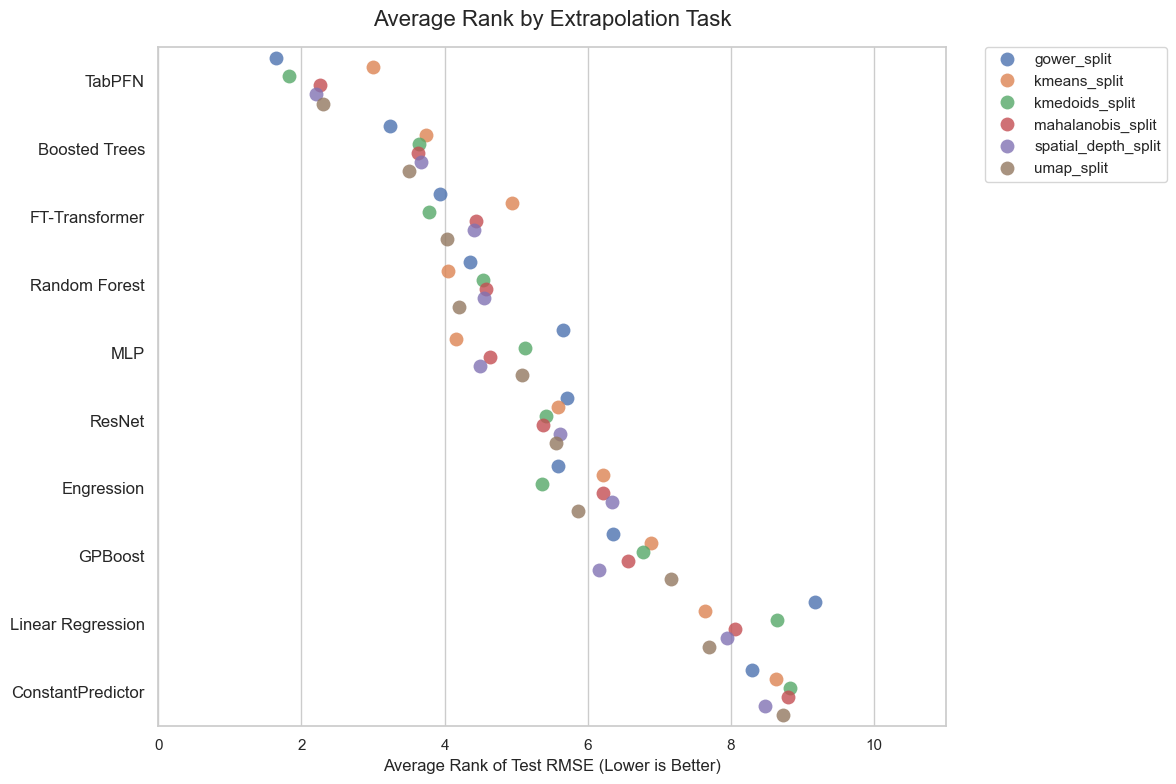

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1 & 2. Load and Prepare Data (Same as above) ---
df = pd.read_csv("results_full.csv")
metric = "RMSE"
df = df[df["metric"] == metric]
df = df[df["split_method"] != "random_split"]
df["rank"] = df.groupby(["split_method", "task_id"])["value"].rank(ascending=True)

# **Calculate mean rank per model AND per split method**
per_split_ranks = df.groupby(['model', 'split_method'])['rank'].mean().reset_index(name='MeanRank')

# --- 3. Prepare for Plotting (Same as above) ---
rename_map = {
    'RandomForestRegressor': 'Random Forest',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LinearRegressor': 'Linear Regression',
    'TabPFNRegressor': 'TabPFN',
    'GPBoost_RMSE': 'GPBoost'
}
per_split_ranks['Method'] = per_split_ranks['model'].map(rename_map).fillna(per_split_ranks['model'])

# **Sort by the OVERALL mean rank to keep the order logical**
overall_mean = per_split_ranks.groupby('Method')['MeanRank'].mean().sort_values()
order = overall_mean.index

# --- 4. Generate the Detailed Plot ---
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

ax = sns.stripplot(
    data=per_split_ranks,
    x='MeanRank',
    y='Method',
    hue='split_method',
    order=order,      # Use the sorted order based on overall mean
    orient='h',
    s=10,             # Slightly smaller markers
    dodge=True,       # Separate the dots for each split method
    alpha=0.8
)

ax.set_title('Average Rank by Extrapolation Task', fontsize=16, pad=15)
ax.set_xlabel('Average Rank of Test RMSE (Lower is Better)', fontsize=12)
ax.set_ylabel('')
ax.set_xlim(0, 11)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=11)

# Place legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()